# Visualizing wildfires in the study area

Source: Monitoring Trends in Burn Severity (https://www.mtbs.gov/)
Query parameters:

Years: 1984 to 2022
BBOX: -12696469.657074679, 3768398.3048523143, -11473486.192590404, 5012391.43102302 (4 corners area)8
Fire Type: Wildfie


### Visualize fire locations

9462 total fires


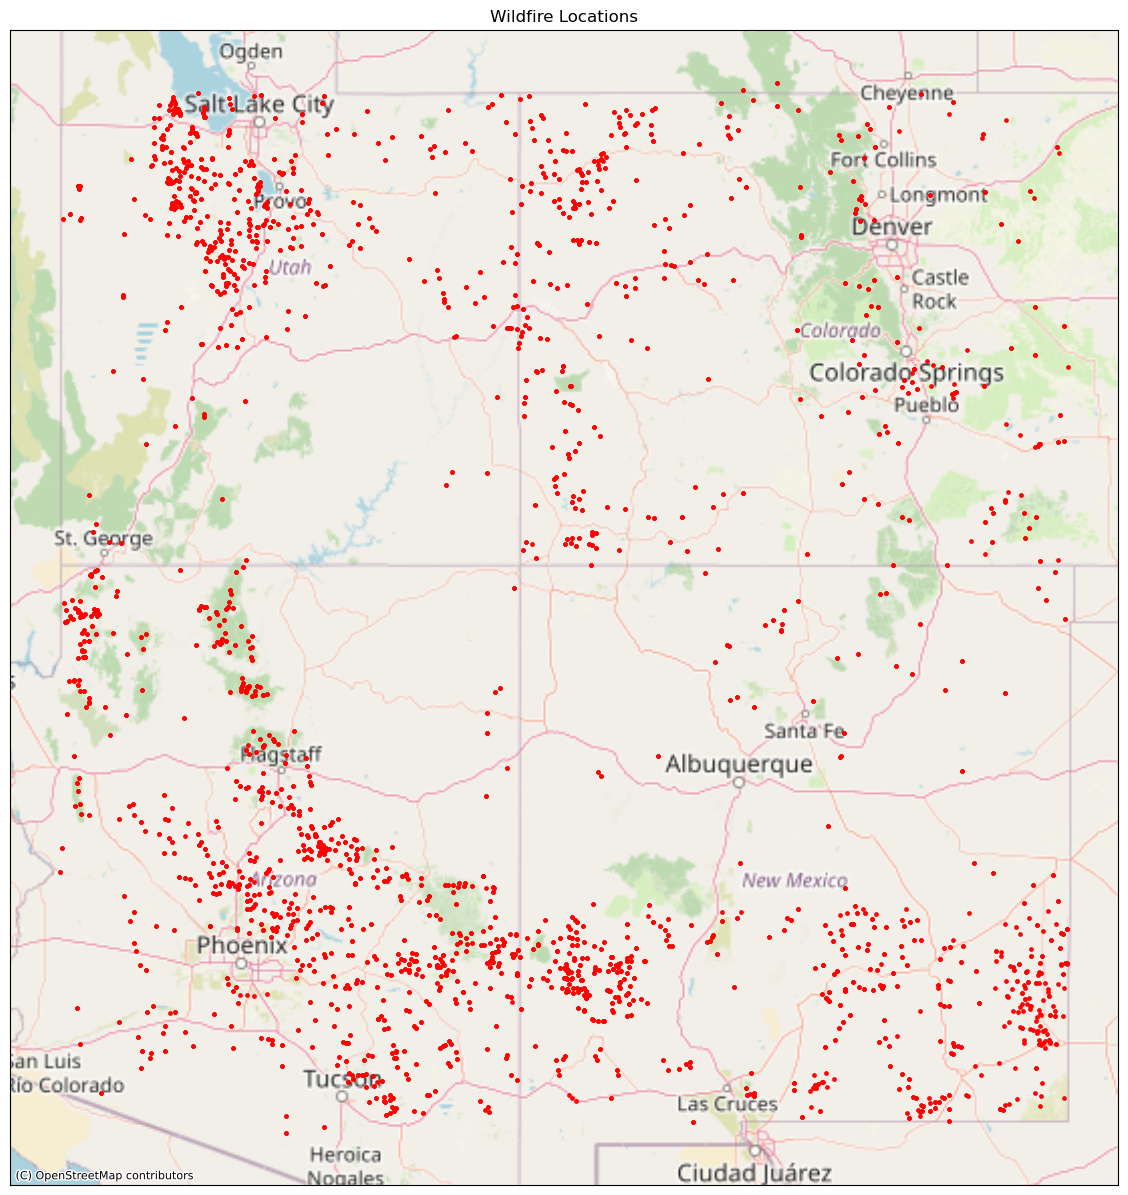

In [1]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import contextily as ctx

# Ensure plots are displayed inline
%matplotlib inline

# Load the CSV data
df = pd.read_csv('MTBS_Wildfire_Data/simplified_fire_data_1984-2024.csv')

# Print rows
print(f"{df.shape[0]} total fires")

# Convert to GeoDataFrame
df['geometry'] = df.apply(lambda row: Point(row['center_lon'], row['center_lat']), axis=1)
gdf = gpd.GeoDataFrame(df, geometry='geometry', crs="EPSG:4326")

# Visualize the fires on a map
def plot_fire_locations(gdf):
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf = gdf.to_crs(epsg=3857)
    gdf.plot(ax=ax, marker='o', color='red', markersize=5, alpha=0.6)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title('Wildfire Locations')
    ax.set_xticks([])
    ax.set_yticks([])
    plt.show()

# Execute the plotting function
plot_fire_locations(gdf)

### Visualize burn severity

Burn severity rasters contain pixel values that represent the severity of burns over the entire area of the fire. By averaging these pixel values, we get a single number that summarizes the overall severity across the entire burn area.

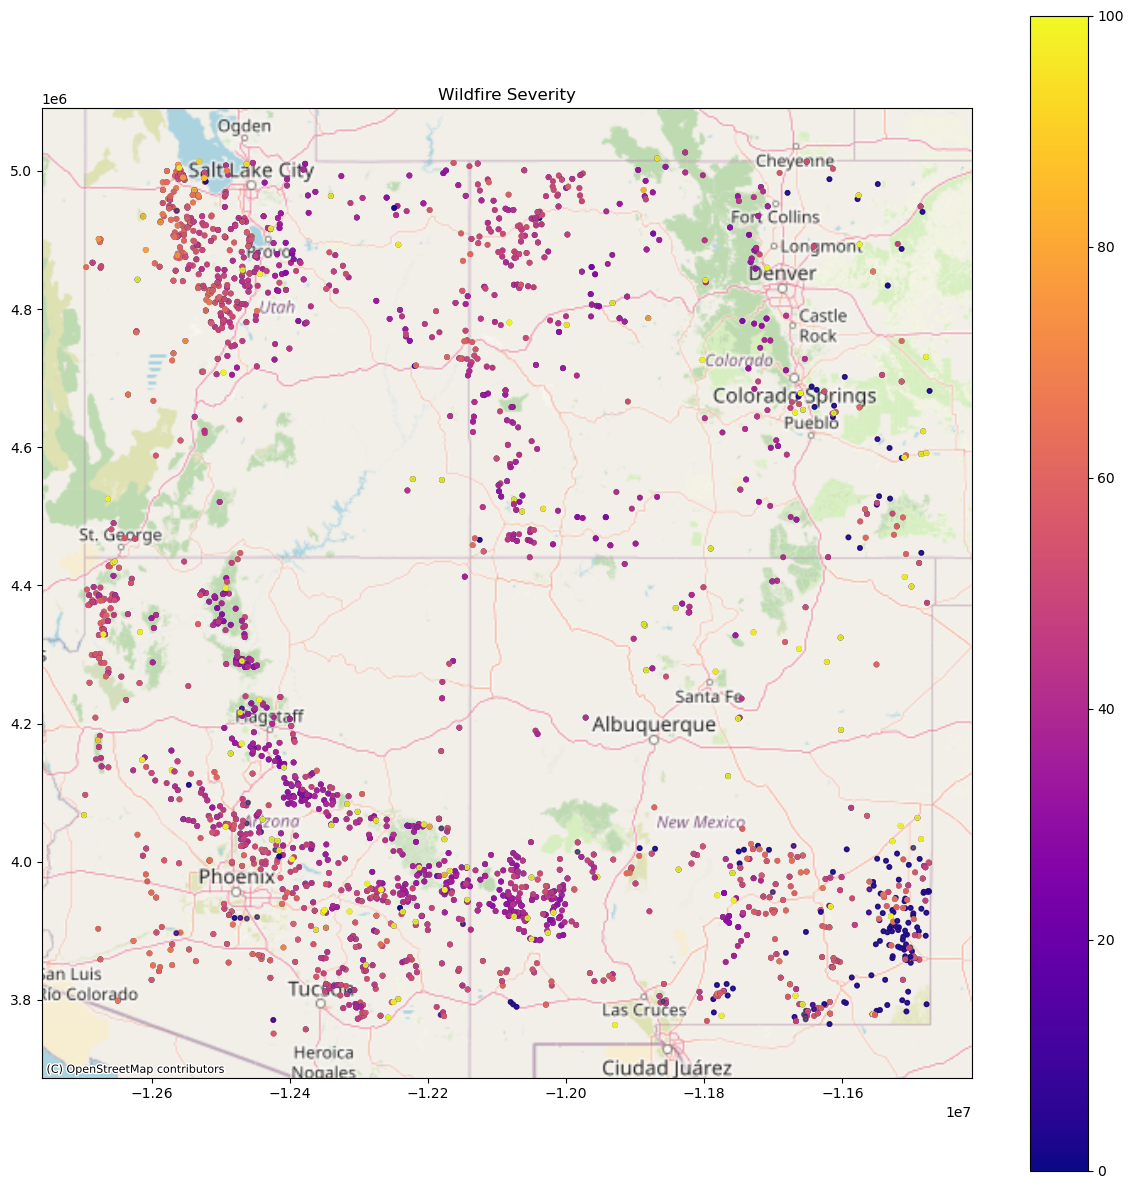

In [2]:
# Clamp the average_severity values between -500 and 300
gdf['average_severity'] = gdf['average_severity'].clip(lower=000, upper=100)

# Visualize the average severity of fires
def plot_fire_severity(gdf):
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf = gdf.to_crs(epsg=3857)
    gdf.plot(ax=ax, marker='o', column='average_severity', cmap='plasma', markersize=10, alpha=0.6, legend=True, vmin=000, vmax=100)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title('Wildfire Severity')
    plt.show()

# Plot the fire severity
plot_fire_severity(gdf)

### Visualize fire sizes

Some fires were as large as 46,000 acres, but the average was around 8,000 acres so we cap the plot at 15,000 to maintain some visual gradient.

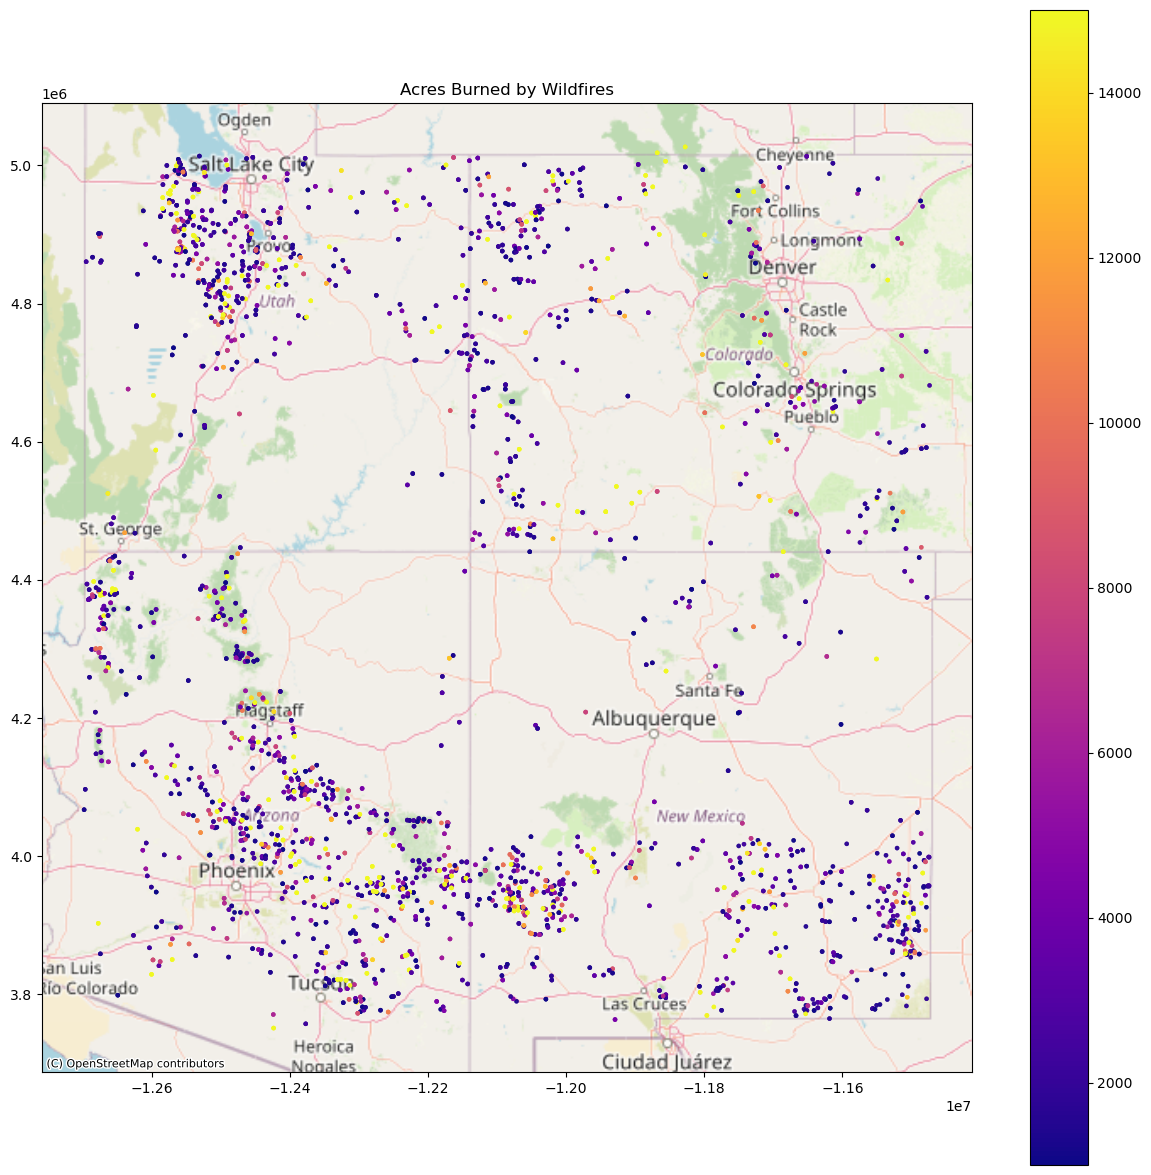

In [3]:
# Clamp the acreage values between 1000 and 15000
gdf['acres'] = gdf['acres'].clip(lower=1000, upper=15000)

# Visualize the acres burned by each fire
def plot_fire_acres(gdf):
    fig, ax = plt.subplots(figsize=(15, 15))
    gdf = gdf.to_crs(epsg=3857)
    gdf.plot(ax=ax, marker='o', column='acres', cmap='plasma', markersize=5, alpha=0.6, legend=True)
    ctx.add_basemap(ax, crs=gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title('Acres Burned by Wildfires')
    plt.show()

plot_fire_acres(gdf)

### Wildfires by time in study area

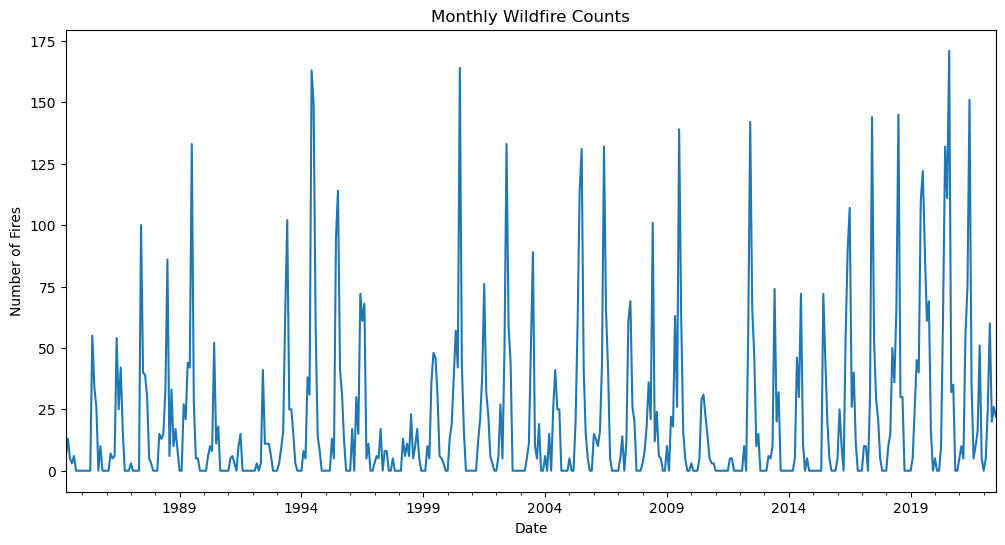

In [4]:
# Visualize the temporal distribution of fires
def plot_fire_dates(gdf):
    gdf['fire_date'] = pd.to_datetime(gdf['fire_date'])
    gdf.set_index('fire_date', inplace=True)
    monthly_counts = gdf.resample('M').size()

    fig, ax = plt.subplots(figsize=(12, 6))
    monthly_counts.plot(ax=ax)
    ax.set_title('Monthly Wildfire Counts')
    ax.set_xlabel('Date')
    ax.set_ylabel('Number of Fires')
    plt.show()

plot_fire_dates(gdf)

## Visualizing where water quality sampling sites are in the study area

Source: USGS (waterqualitydata.us)\
Query parameters:

Bounding Box: -114.054488%2C32.020937%2C -103.072302%2C40.955686\
Sampling Media: Water\
Start date: 01-01-2019\
End date: 05-01-2024\
Sources: NWIS, STORET\
Characteristics:
- *Turbidity*
- *Dissolved oxygen*
- *Mean PEC Quotient - Metals*
- *Temperature*
- *pH*

This is only inclusive from 2019-2024 and is meant to give an understanding of the general areas of where the sampling sites are. In practice it would make more sense to query the USGS database with the specific time frame and area around the fire to get streamlined results.

5440 total water quality sampling sites


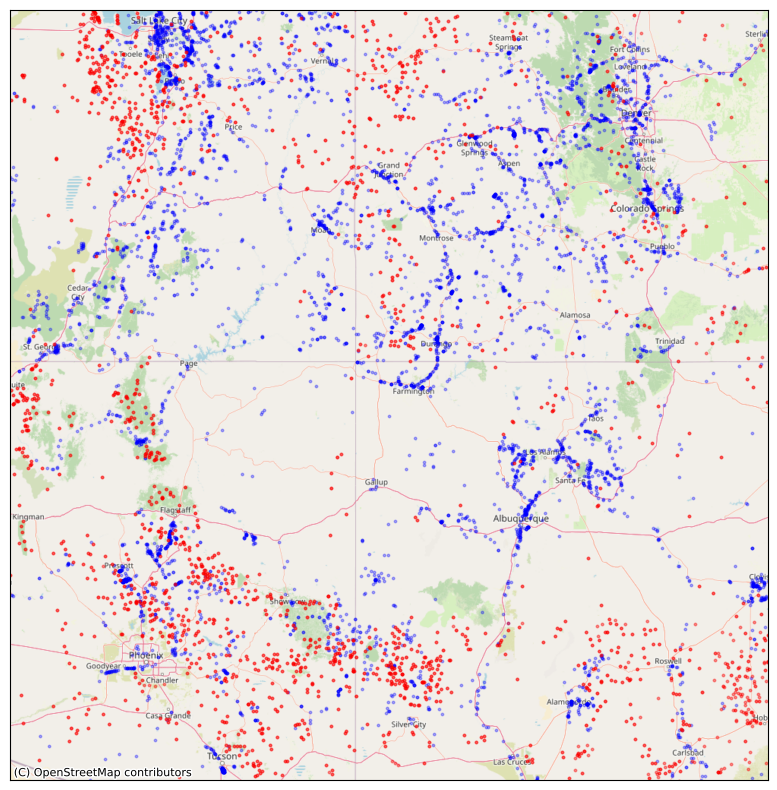

In [21]:
# Load the USGS water quality sites CSV
usgs_df = pd.read_csv('USGS_Water_Quality_Sites/wq_site_information.csv')
mtbs_df = pd.read_csv('MTBS_Wildfire_Data/simplified_fire_data_1984-2024.csv')

# Print rows
print(f"{usgs_df.shape[0]} total water quality sampling sites")

# Rename columns for easier access
usgs_df = usgs_df.rename(columns={
    'MonitoringLocationIdentifier': 'site_id',
    'LatitudeMeasure': 'lat',
    'LongitudeMeasure': 'long'
})

# Create a geometry column
usgs_df['geometry'] = usgs_df.apply(lambda row: Point(row['long'], row['lat']), axis=1)
mtbs_df['geometry'] = mtbs_df.apply(lambda row: Point(row['center_lon'], row['center_lat']), axis=1)

# Convert to GeoDataFrame
usgs_gdf = gpd.GeoDataFrame(usgs_df, geometry='geometry', crs="EPSG:4326")
mtbs_gdf = gpd.GeoDataFrame(mtbs_df, geometry='geometry', crs="EPSG:4326")

# Check for valid geometries
usgs_gdf = usgs_gdf[usgs_gdf.is_valid]

# Remove rows with missing geometries
usgs_gdf = usgs_gdf.dropna(subset=['geometry'])

# Set the plot size
fig, ax = plt.subplots(figsize=(10, 10))

# Convert GeoDataFrame to the correct CRS
usgs_gdf = usgs_gdf.to_crs(epsg=3857)
mtbs_gdf = mtbs_gdf.to_crs(epsg=3857)

# Plot the GeoDataFrames
usgs_gdf.plot(ax=ax, marker='o', color='blue', markersize=3, alpha=0.3)
mtbs_gdf.plot(ax=ax, marker='o', color='red', markersize=3, alpha=0.15)


# Manually set the extent
minx, miny, maxx, maxy = usgs_gdf.total_bounds
ax.set_xlim(minx, maxx)
ax.set_xticks([])
ax.set_ylim(miny, maxy)
ax.set_yticks([])

# Add basemap using contextily
ctx.add_basemap(ax, crs=usgs_gdf.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)

# Show the plot
plt.show()

## Visualizing hydrologic data

Reading file


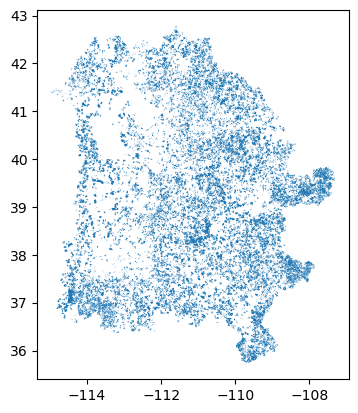

In [22]:
shapefile_path = "NHD_Watershed_Shapefiles/Utah/NHDFlowline.shp"

print("Reading file")
# Load the shapefile into a GeoDataFrame
gdf = gpd.read_file(shapefile_path)

# Plot the GeoDataFrame
gdf.plot()

# Show the plot
plt.show()

## Visualizing the watershed directionality (where is the water heading?)

In [4]:
# Load NHD flowline shapefiles
nhd_directory = 'NHD_Watershed_Shapefiles'

# Find the shapefiles
shapefiles = []
for root, dirs, files in os.walk(nhd_directory):
    for file in files:
        if file.endswith('.shp'):
            base_name = os.path.splitext(os.path.join(root, file))[0]
            if os.path.exists(base_name + '.shx') and os.path.exists(base_name + '.dbf'):
                shapefiles.append(os.path.join(root, file))

# Create a list of them to concat together
flowlines_list = []
for shapefile in shapefiles:
    try:
        print(f"Appending flowlines from {shapefile}")
        gdf = gpd.read_file(shapefile)
        print(f"Appended flowlines from {shapefile}")
        flowlines_list.append(gdf)
    except Exception as e:
        print(f"Error reading {shapefile}: {e}")

# If we found shapefiles:
if flowlines_list:
    # Concat them together to create 1 shapefile with our hydrologic data
    nhd_flowlines = gpd.GeoDataFrame(pd.concat(flowlines_list, ignore_index=True))

    # Save the GDF as a shapefile for ease of access
    gdf.to_file("concatenated_flowlines.shp")
    print("Concatenated GDFs")

    # Ensure all GeoDataFrames have the same CRS
    mtbs_gdf = mtbs_gdf.to_crs(nhd_flowlines.crs)
    usgs_gdf = usgs_gdf.to_crs(nhd_flowlines.crs)

    # Function to find the closest flowline segment to a given point
    def find_closest_flowline(point, flowlines):
        return flowlines.distance(point).idxmin()

    # Function to trace the downstream path from a given flowline segment
    def trace_downstream(flowline_id, graph):
        downstream_path = []
        current_id = flowline_id
        
        while current_id in graph:
            downstream_path.append(current_id)
            try:
                current_id = list(graph.successors(current_id))[0]
            except IndexError:
                break
        
        return downstream_path

    # Map flow directions using FlowDir attribute
    def map_flow_directions(flowlines):
        flow_direction = {}
        for idx, row in flowlines.iterrows():
            next_downstream_id = row['FlowDir']
            if next_downstream_id != -1:
                flow_direction[idx] = next_downstream_id
        return flow_direction

    flow_direction = map_flow_directions(nhd_flowlines)

    # Create a directed graph for the flowlines
    G = nx.DiGraph()
    for idx, row in nhd_flowlines.iterrows():
        if row['FlowDir'] != -1:
            G.add_edge(row['HydroID'], row['FlowDir'])

    # Find the downstream water quality site for each fire site
    results = []

    for fire in mtbs_gdf.itertuples():
        closest_flowline_id = find_closest_flowline(fire.geometry, nhd_flowlines)
        downstream_path_ids = trace_downstream(closest_flowline_id, G)
        downstream_flowlines = nhd_flowlines[nhd_flowlines['HydroID'].isin(downstream_path_ids)]
        
        closest_downstream_site = usgs_gdf[usgs_gdf.intersects(downstream_flowlines.unary_union)].distance(fire.geometry).idxmin()
        closest_site_info = usgs_gdf.loc[closest_downstream_site]
        
        results.append({
            'fire_id': fire.Index,
            'center_lat': fire.center_lat,
            'center_lon': fire.center_lon,
            'downstream_site_id': closest_site_info['site_id'],
            'downstream_site_lat': closest_site_info['lat'],
            'downstream_site_lon': closest_site_info['long']
        })

    results_df = pd.DataFrame(results)
    final_mtbs_df = mtbs_df.merge(results_df[['fire_id', 'downstream_site_id']], left_index=True, right_on='fire_id')

    final_mtbs_df.to_csv('updated_mtbs_output.csv', index=False)
    print("MTBS data has been updated with the nearest downstream water quality site IDs.")

    # Plot the flowlines with basemap
    fig, ax = plt.subplots(figsize=(15, 15))
    nhd_flowlines = nhd_flowlines.to_crs(epsg=3857)
    nhd_flowlines.plot(ax=ax, color='blue', linewidth=0.5)
    ctx.add_basemap(ax, crs=nhd_flowlines.crs.to_string(), source=ctx.providers.OpenStreetMap.Mapnik)
    plt.show()

Appending flowlines from NHD_Watershed_Shapefiles/Arizona/NHDFlowline_0.shp
Error reading NHD_Watershed_Shapefiles/Arizona/NHDFlowline_0.shp: 'NHD_Watershed_Shapefiles/Arizona/NHDFlowline_0.shp' not recognized as a supported file format.
Appending flowlines from NHD_Watershed_Shapefiles/Arizona/NHDFlowline_1.shp
Error reading NHD_Watershed_Shapefiles/Arizona/NHDFlowline_1.shp: 'NHD_Watershed_Shapefiles/Arizona/NHDFlowline_1.shp' not recognized as a supported file format.
Appending flowlines from NHD_Watershed_Shapefiles/Colorado/NHDFlowline_0.shp
Error reading NHD_Watershed_Shapefiles/Colorado/NHDFlowline_0.shp: <class 'fiona.ogrext.FeatureBuilder'> returned a result with an exception set
Appending flowlines from NHD_Watershed_Shapefiles/Colorado/NHDFlowline_1.shp


KeyboardInterrupt: 